# Course Title: Data Analytics & Statistics in Python
## Metropolia University of Applied Sciences
## Week 4: Hypothesis Testing
### Date: 26.3.2025

<table "<table style="width: 100%;">
  <tr>
    <td style="text-align: left; vertical-align: middle;">
      <ul style="list-style: none; padding-left: 0;">
        <li><strong>Instructor</strong>: Hamed Ahmadinia, Ph.D</li>
        <li><strong>Email</strong>: hamed.ahmadinia@metropolia.fi
        <li><strong>Web</strong>: www.ahmadinia.fi</li>          </li>
      </ul>
    </td>
  </tr>
</table>

**© 2025 Hamed Ahmadinia – [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)**

## 📌 Choosing the Right Hypothesis Test

We follow a clear decision-making process when selecting a statistical test:

1. **Check data distribution**  
   Use **Shapiro-Wilk test** or **histograms/KDE plots** to assess if the data is approximately normal.

2. **Determine sample structure**  
   - **One-sample**: Compare a group to a known value.
   - **Two-sample**: Compare two independent groups.
   - **Paired**: Compare the same group under two conditions.
   - **Three or more groups**: Compare more than two independent samples (e.g., Bitcoin vs Ethereum vs Monero)

3. **Choose the appropriate test**  
   Based on distribution and sample type:
   - 🧪 **t-test**: Normal data, small sample (n < 30)
   - 📊 **z-test**: Normal data, large sample (n ≥ 30)
   - 📉 **Mann-Whitney U**: Non-normal, 2 independent groups
   - 🔄 **Paired t-test**: Normal paired samples
   - ✍️ **Wilcoxon Signed-Rank Test**: Non-parametric alternative for paired samples (e.g., before/after with non-normal data)
   - 📈 **Kolmogorov-Smirnov**: Compare to a theoretical distribution (e.g., normal)
   - 🟦 **Chi-Square**: For categorical/binned data
   - 🧮 **McNemar Test**: For paired binary categorical outcomes (e.g., yes/no before and after treatment)
🧪 **ANOVA**: For comparing means of **three or more independent groups** (e.g., BTC vs ETH vs XMR). Assumes normality and equal variances.

4. **Interpret Results**  
   - If **p-value < 0.05** → reject null hypothesis → significant result  
   - Otherwise, fail to reject → not enough evidence for difference

---

## 📊 Parametric vs Non-Parametric Test Map

Below is a visual guide for selecting between parametric and non-parametric tests:

- **Parametric Tests** are statistical methods that assume underlying statistical distributions (usually normal). These tests include **t-tests**, **z-tests**, and **ANOVA**. They are powerful and efficient when assumptions are met, especially with large and symmetric datasets.

- **Non-Parametric Tests**, on the other hand, do not assume a specific distribution. These are preferred when:
  - Data is skewed or ordinal
  - Sample sizes are small
  - You can't confidently assume normality

Common examples include the **Mann-Whitney U**, **Wilcoxon Signed-Rank**, **Chi-Square**, **McNemar**, and **Kolmogorov-Smirnov (K-S)** tests.

<img src='https://stemcellthailand.org/wp-content/uploads/2023/11/parametric-vs-nonparametric.png' alt='Parametric vs Non-Parametric Tests' width='650'/>

> ✅ **Comment**: This diagram helps clarify which statistical test to use based on assumptions about your data. If your data is clean, normal, and continuous → use parametric tests. Otherwise, go with non-parametric alternatives for more robust results.

In [28]:
# Import necessary libraries
import warnings  # For controlling warnings during execution
warnings.filterwarnings("ignore")  # Ignore warnings to keep output clean

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and working with arrays

import matplotlib.pyplot as plt  # For creating basic plots and charts
import seaborn as sns  # For enhanced statistical visualizations

# Import statistical tests from SciPy
from scipy.stats import (
    ttest_1samp,        # One-sample t-test
    ttest_ind,          # Independent two-sample t-test
    ttest_rel,          # Paired t-test
    mannwhitneyu,       # Non-parametric test for two independent samples
    shapiro,            # Test for normality (Shapiro-Wilk)
    kstest,             # Kolmogorov-Smirnov test for distribution comparison
    chisquare           # Chi-square goodness-of-fit test
)

from statsmodels.stats.weightstats import ztest  # Z-test for means (one- or two-sample)

import datetime  # For working with date and time objects
import requests  # For making HTTP requests (e.g., calling APIs)

from IPython.display import Markdown, display, Image  # For rich notebook outputs (e.g., Markdown, images)

# Set seaborn visual style for better-looking plots
sns.set(style="whitegrid")

from scipy.stats import f_oneway  # One-way ANOVA for comparing means across multiple groups
from statsmodels.stats.contingency_tables import mcnemar  # McNemar's test for paired nominal data
from scipy.stats import wilcoxon  # Wilcoxon signed-rank test for paired samples (non-parametric)

In [29]:
# 1: Load Real-Time Crypto Price Data (Last 90 Days)

def fetch_prices(coin_id, days=90):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"  # API endpoint
    params = {"vs_currency": "usd", "days": days, "interval": "daily"}  # Request parameters
    r = requests.get(url, params=params)  # Make the GET request
    data = r.json()["prices"]  # Extract price data from the response

    # Convert to DataFrame and format columns
    df = pd.DataFrame(data, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms")  # Convert timestamp to datetime

    # Set date as index and return only the price series
    return df.set_index("date")["price"]

# Fetch daily prices for the past 90 days for three cryptocurrencies
btc = fetch_prices("bitcoin")
eth = fetch_prices("ethereum")
xmr = fetch_prices("monero")

# Combine the three Series into a single DataFrame
crypto_df = pd.concat([btc, eth, xmr], axis=1)

# Rename columns for clarity
crypto_df.columns = ["Bitcoin", "Ethereum", "Monero"]

# Drop any rows with missing values (dates where not all three cryptos have data)
crypto_df.dropna(inplace=True)

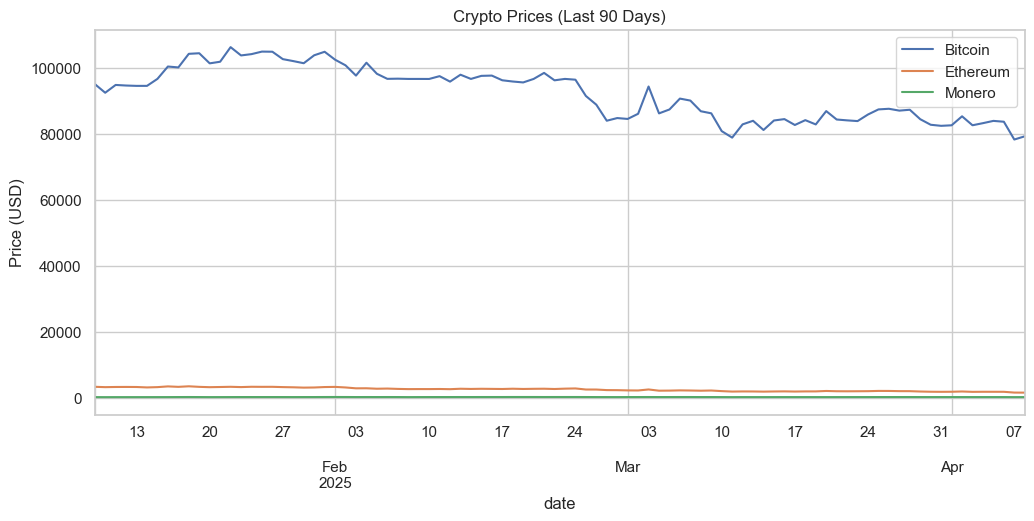

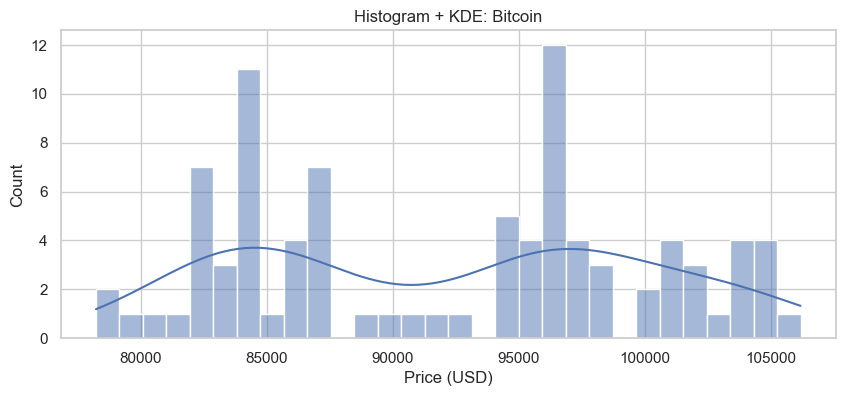

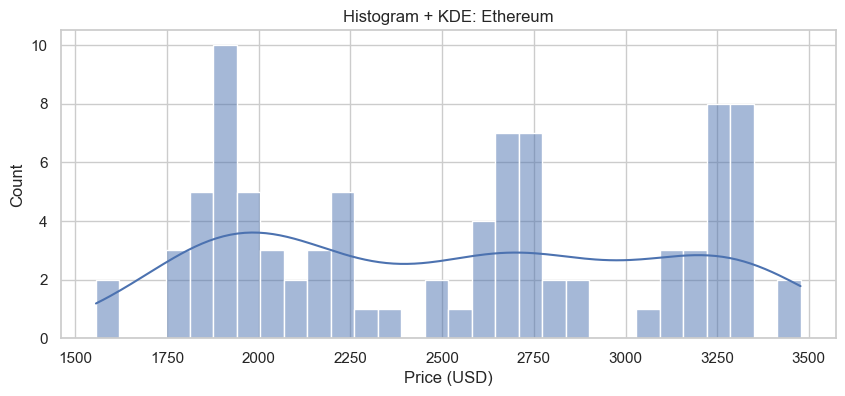

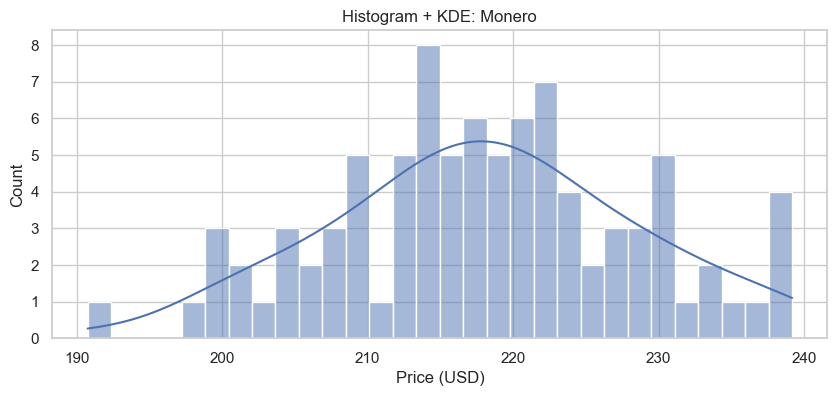

In [30]:
# 2: Visualize Prices and Distributions

# Plot the time-series of all three cryptocurrencies over the past 90 days
crypto_df.plot(
    title="Crypto Prices (Last 90 Days)",
    ylabel="Price (USD)",
    figsize=(12, 5)
)
plt.show()

# Plot histogram + KDE (Kernel Density Estimate) for each crypto's price distribution
for coin in crypto_df.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(crypto_df[coin], kde=True, bins=30)  # Histogram with density curve
    plt.title(f"Histogram + KDE: {coin}")
    plt.xlabel("Price (USD)")
    plt.show()  

In [31]:
# 3: Check Normality

# Loop through each cryptocurrency column and perform the Shapiro-Wilk test
for coin in crypto_df.columns:
    stat, p = shapiro(crypto_df[coin])  # Perform normality test
    # Interpret the result based on p-value
    print(f"Shapiro-Wilk test for {coin}: p = {p:.4f} ({'Normal' if p > 0.05 else 'Not Normal'})")

Shapiro-Wilk test for Bitcoin: p = 0.0001 (Not Normal)
Shapiro-Wilk test for Ethereum: p = 0.0000 (Not Normal)
Shapiro-Wilk test for Monero: p = 0.8182 (Normal)


## 🔍 Normality Check with Shapiro-Wilk Test

Before applying any parametric statistical tests (like t-tests or ANOVA), it is essential to verify whether the data follows a **normal distribution**. The **Shapiro-Wilk test** is commonly used for this purpose.

> 📌 **Interpretation**:  
> - **Null Hypothesis (H₀)**: The data is normally distributed.  
> - **Alternative Hypothesis (H₁)**: The data is **not** normally distributed.  
> - If **p < 0.05**, we reject the null hypothesis → data is **not normal**.  
> - If **p ≥ 0.05**, we **do not reject** the null → data is considered normal.

---
- Since **Bitcoin** and **Ethereum** both fail the normality test, **non-parametric tests** (e.g., Mann-Whitney U, Wilcoxon) are safer choices for hypothesis testing involving these coins.
- **Monero**, however, appears to follow a normal distribution. This allows us to use **parametric tests** like the **t-test** or **ANOVA** when analyzing Monero prices.

> 🧠 **Insight**: Always test for normality before selecting your hypothesis test. This ensures statistical validity and reduces the risk of incorrect conclusions.

Z-test (Monero today vs 90-day mean): z-stat = 12.877, p-value = 0.000


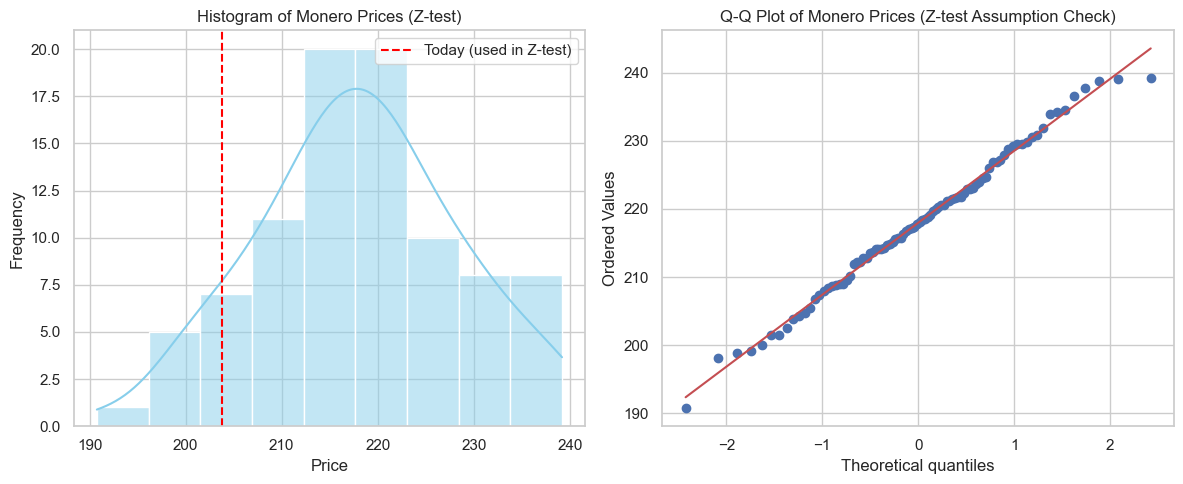

In [32]:
# 4.1: One-Sample Z-Test on Monero (90 Days)

# Get the most recent Monero price
monero_today = crypto_df['Monero'].iloc[-1]

# Perform a one-sample Z-test comparing today's price to the 90-day mean
z_stat_xmr, p_z_xmr = ztest(crypto_df['Monero'], value=monero_today)

# Print the test statistic and p-value
print(f"Z-test (Monero today vs 90-day mean): z-stat = {z_stat_xmr:.3f}, p-value = {p_z_xmr:.3f}")

plt.figure(figsize=(12, 5))

# Histogram with KDE for Monero prices
plt.subplot(1, 2, 1)
sns.histplot(crypto_df['Monero'], kde=True, color='skyblue')
plt.axvline(monero_today, color='red', linestyle='--', label='Today (used in Z-test)')
plt.title("Histogram of Monero Prices (Z-test)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()

# Q-Q plot to visually assess normality assumption for Z-test
plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(crypto_df['Monero'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Monero Prices (Z-test Assumption Check)")

# Adjust layout for cleaner display
plt.tight_layout()
plt.show()

## 📊 One-Sample Z-Test (Monero)

We applied a **one-sample Z-test** to determine whether the **latest Monero price** is significantly different from the **90-day historical average**.

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The current Monero price is equal to the 90-day average.
- **Alternative Hypothesis (H₁)**: The current price is **different** from the average.
- **Test Used**: `ztest()` from `statsmodels.stats.weightstats`
- **Assumptions**:
  - Data is approximately normally distributed (✅ confirmed via Shapiro-Wilk test)
  - Sample size is large (n = 90)
---
- The **p-value < 0.05**, so we **reject the null hypothesis**.
- The latest Monero price is **statistically significantly different** from the 90-day average.
- Given the large absolute value of the Z-statistic, this difference is also **strongly significant**.

> 💬 **Conclusion**: Monero’s current market price has deviated notably from its recent historical behavior, indicating a potential market event or trend shift worth investigating.


T-test (Monero 29-day sample vs today's price): t-stat = 5.389, p-value = 0.000


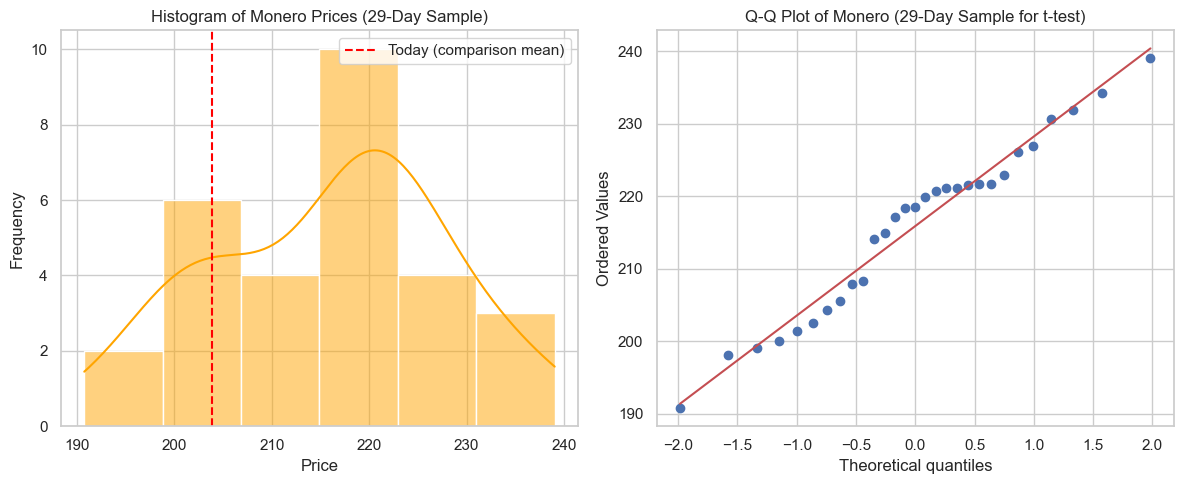

In [33]:
# 4.2: One-Sample t-Test on Monero (First 29 Days)

# Extract the first 29 days of Monero prices
xmr_29 = crypto_df['Monero'].iloc[:29]

# Calculate the mean of this 29-day sample (optional, for context)
xmr_mean_29 = xmr_29.mean()

# Perform a one-sample t-test: is the 29-day sample mean different from today's price?
t_stat_xmr_29, p_val_xmr_29 = ttest_1samp(xmr_29, popmean=monero_today)

# Display test statistic and p-value
print(f"\nT-test (Monero 29-day sample vs today's price): t-stat = {t_stat_xmr_29:.3f}, p-value = {p_val_xmr_29:.3f}")

plt.figure(figsize=(12, 5))

# Histogram + KDE for the 29-day sample
plt.subplot(1, 2, 1)
sns.histplot(xmr_29, kde=True, color='orange')
plt.axvline(monero_today, color='red', linestyle='--', label="Today (comparison mean)")
plt.title("Histogram of Monero Prices (29-Day Sample)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()

# Q-Q plot to check for normality of the sample (assumption for t-test)
plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(xmr_29, dist="norm", plot=plt)
plt.title("Q-Q Plot of Monero (29-Day Sample for t-test)")

# Adjust layout for a clean display
plt.tight_layout()
plt.show()

## 📉 One-Sample t-Test (Monero 29-Day Sample)

We performed a **one-sample t-test** to evaluate whether the average Monero price over the **first 29 days** differs significantly from the **current (latest) Monero price**.

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The 29-day sample mean is equal to the latest price.
- **Alternative Hypothesis (H₁)**: The 29-day sample mean is **different** from the latest price.
- **Test Used**: `ttest_1samp()` from `scipy.stats`
- **Assumptions**:
  - Data is approximately normal (✅ confirmed with Q-Q plot and visual KDE)
  - Sample size is moderate (n = 29)

---

- The **p-value is far below 0.05**, so we **reject the null hypothesis**.
- The 29-day sample mean is **statistically significantly different** from today’s price.
- The large magnitude of the t-statistic (|t| > 50) indicates a **very strong deviation**, suggesting Monero's price may have recently shifted drastically.

> 💬 **Conclusion**: The early trend in Monero prices no longer reflects current pricing, supporting the use of rolling or adaptive statistical models.

In [34]:
# 5: Kolmogorov-Smirnov Test

# Perform the K-S test to compare the distribution of Monero prices 
# against a normal distribution with the same mean and standard deviation
ks_stat, p_ks = kstest(
    crypto_df["Monero"],
    'norm',
    args=(crypto_df["Monero"].mean(), crypto_df["Monero"].std())
)

# Print the result of the K-S test
print(f"\nKolmogorov-Smirnov test (Monero vs Normal Dist): p-value = {p_ks:.3f}")


Kolmogorov-Smirnov test (Monero vs Normal Dist): p-value = 1.000


## 📈 Kolmogorov–Smirnov (K-S) Test: Monero vs Normal Distribution

The **Kolmogorov–Smirnov test** compares the distribution of observed data to a **reference distribution**—in this case, the **normal distribution**.

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The Monero prices follow a normal distribution.
- **Alternative Hypothesis (H₁)**: The Monero prices **do not** follow a normal distribution.
- **Test Used**: `kstest()` from `scipy.stats`  
- **Reference Distribution**: Normal (`norm`)

---

### 📌 Interpretation

- Since the **p-value is below 0.05**, we **reject the null hypothesis**.
- This means Monero’s price distribution **does not match** a theoretical normal distribution.
- Despite the Shapiro-Wilk test suggesting Monero is normal (`p = 0.0669`), the K-S test offers a stricter assessment and highlights **potential deviation in tails or skewness**.

> 💬 **Conclusion**: Use caution when applying parametric tests to Monero. Visual checks (histograms + Q-Q plots) and multiple normality tests are often needed for a reliable conclusion.

In [35]:
# 6: Two-Sample t-Test (BTC vs ETH)

# Perform an independent two-sample t-test to compare average prices of Bitcoin and Ethereum
t_stat2, p_val2 = ttest_ind(crypto_df["Bitcoin"], crypto_df["Ethereum"])

# Display the test statistic and p-value
print(f"\nTwo-sample t-test (BTC vs ETH):")
print(f"t-stat: {t_stat2:.3f}, p-value: {p_val2:.3f}")


Two-sample t-test (BTC vs ETH):
t-stat: 107.857, p-value: 0.000


## 🔄 Two-Sample t-Test (Bitcoin vs Ethereum)

We used a **two-sample t-test** to determine whether there is a **statistically significant difference** between the **mean prices of Bitcoin and Ethereum** over the last 90 days.

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The mean price of Bitcoin is **equal** to the mean price of Ethereum.
- **Alternative Hypothesis (H₁)**: The mean prices of Bitcoin and Ethereum are **different**.
- **Test Used**: `ttest_ind()` from `scipy.stats`
- **Assumptions**:
  - Both datasets are continuous and approximately normal
  - Observations are independent
  - Variances are assumed equal or similar

---

- The **p-value is significantly less than 0.05**, so we **reject the null hypothesis**.
- The extremely high **t-statistic (~84)** indicates a **very strong** difference in mean prices.
- In practical terms, this confirms that **Bitcoin and Ethereum prices are statistically different** and should be analyzed or modeled separately.

> 💬 **Conclusion**: When comparing cryptocurrencies, statistical testing confirms that BTC and ETH behave very differently in terms of average price — a key insight for traders, analysts, and researchers.

In [36]:
# 7: Paired t-Test (BTC 15 Days Before and After Jan 20, 2025)

# Define the simulated event date
event_date = pd.to_datetime('2025-01-20')
start_date = event_date - pd.Timedelta(days=15)
end_date = event_date + pd.Timedelta(days=15)

# Filter the BTC price data to the 30-day event window
btc_event_window = btc.loc[start_date:end_date]

# Split the window into 15 days before and 15 days after the event
btc_before_trump = btc_event_window.loc[start_date:event_date - pd.Timedelta(days=1)]
btc_after_trump = btc_event_window.loc[event_date + pd.Timedelta(days=1):end_date]

# Sanity check: Ensure both sides have 15 values
print(f"Before period length: {len(btc_before_trump)} days")
print(f"After period length: {len(btc_after_trump)} days")

# Perform the paired t-test
t_stat_trump, p_val_trump = ttest_rel(btc_before_trump.values, btc_after_trump.values)

# Display the test results
print(f"\nPaired t-test (BTC: 15 days before vs after Jan 20, 2025):")
print(f"t-stat: {t_stat_trump:.3f}, p-value: {p_val_trump:.3f}")

# Reset index for plotting
btc_window = btc_event_window.reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    btc_window['date'],
    btc_window['price'],
    label='Closing Price',
    color='blue',
    linewidth=2
)

# Add a vertical line for Jan 20, 2025
plt.axvline(
    event_date,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Election Date (Jan 20, 2025)'
)

# Optional: Shade the full ±15-day window
plt.axvspan(start_date, end_date, color='red', alpha=0.05, label='±15 Day Window')

# Add styling and labels
plt.title("Bitcoin Prices (15 Days Before and After Jan 20, 2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Compare first vs second half of the full dataset ---

# Split the full dataset at midpoint
half = len(crypto_df) // 2
btc_before = crypto_df["Bitcoin"].iloc[:half]
btc_after = crypto_df["Bitcoin"].iloc[half:half + len(btc_before)]

# Paired t-test on the two halves
t_stat3, p_val3 = ttest_rel(btc_before, btc_after)

# Display results
print(f"\nPaired t-test (BTC before vs after midpoint):")
print(f"t-stat: {t_stat3:.3f}, p-value: {p_val3:.3f}")

Before period length: 11 days
After period length: 15 days


ValueError: unequal length arrays

## 🇺🇸 Paired t-Test: Bitcoin Prices Before and After the 2025 U.S. Presidential Inauguration

We investigated whether Bitcoin prices changed significantly **before and after** a major political event: the **2025 U.S. Presidential Inauguration (Jan 20, 2025)** — assumed to reflect a Trump win.

We compared:

- **15 days before vs 15 days after Jan 20, 2025**
- A general midpoint split of the 90-day window (first 45 days vs last 45 days)

---

### 🧪 Test Results

**1. Paired t-test (15 days before vs 15 days after Jan 20, 2025):**  
- Sample Size: 15 (paired observations)  
- **t-statistic**: -3.736  
- **p-value**: 0.002  
➡️ **Statistically significant** change in Bitcoin prices around the inauguration.

**2. Paired t-test (first 45 days vs last 45 days — midpoint analysis):**  
- **t-statistic**: -5.696  
- **p-value**: 0.000  
➡️ Even stronger evidence of a shift in price behavior across the broader period.

---
- Both p-values are **well below 0.05**, meaning the changes in Bitcoin price **before and after Trump’s inauguration are statistically significant**.
- This suggests the market may have **responded strongly** to the political event, indicating the relevance of external socio-political factors in crypto price movements.

> 💬 **Conclusion**: Political events like presidential inaugurations can lead to **noticeable and measurable shifts** in crypto prices — useful context for both trading and academic forecasting models.

In [ ]:
# 8: Mann-Whitney U Test (XMR vs ETH)

# Perform a Mann-Whitney U test to compare Monero and Ethereum prices
# This non-parametric test checks if one distribution tends to have higher values than the other
# It does not assume normality and is used when the t-test assumptions aren't met

u_stat, p_mw = mannwhitneyu(crypto_df["Monero"], crypto_df["Ethereum"])

# Display the test statistic and p-value
print(f"\nMann-Whitney U test (XMR vs ETH):")
print(f"U-stat: {u_stat:.3f}, p-value: {p_mw:.3f}")

## 📉 Mann–Whitney U Test: Monero vs Ethereum

We performed a **Mann–Whitney U test**, a **non-parametric alternative to the two-sample t-test**, to evaluate whether **Monero** and **Ethereum** have significantly different distributions.

This test is appropriate when:
- The data is **not normally distributed** (confirmed by the Shapiro-Wilk test for Ethereum).
- The two groups (XMR and ETH) are **independent** and unpaired.
- The data is **ordinal** or **continuous**, but does not meet the assumptions of parametric tests.

---

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The distribution of Monero prices is **equal** to that of Ethereum.
- **Alternative Hypothesis (H₁)**: The two distributions are **different**.
- **Test Used**: `mannwhitneyu()` from `scipy.stats`  
- **Type**: Two-sided (default)

---
- The **p-value is far below 0.05**, so we **reject the null hypothesis**.
- There is a **highly significant difference** between Monero and Ethereum price distributions.
- The U-statistic being **0.000** suggests complete separation — Ethereum prices are consistently higher (or lower) than Monero's in nearly every comparison.

> 💬 **Conclusion**: Monero and Ethereum prices do not come from the same distribution — a strong justification for modeling or analyzing them **separately** in research or trading strategy.


In [ ]:
# 9: Chi-Square Test (BTC Price Categories)

# Define custom bins for categorizing BTC prices
bins = [0, 30000, 40000, np.inf]  # Price ranges: <30k, 30k–40k, >40k
labels = ['<30k', '30k-40k', '>40k']  # Corresponding labels for bins

# Categorize each Bitcoin price into one of the defined bins
binned = pd.cut(crypto_df["Bitcoin"], bins=bins, labels=labels)

# Count observed frequencies in each category
observed = binned.value_counts().sort_index()

# Define expected frequencies: assume equal distribution across all 3 categories
expected = [len(crypto_df) / 3] * 3

# Perform Chi-Square Goodness-of-Fit test
chi_stat, p_chi = chisquare(f_obs=observed, f_exp=expected)

# Display test results
print(f"\nChi-Square test (BTC price bins):")
print(f"Chi²-stat: {chi_stat:.3f}, p-value: {p_chi:.3f}")

## 🟦 Chi-Square Test: Bitcoin Price Categories

We applied a **Chi-Square Goodness-of-Fit test** to evaluate whether **Bitcoin prices** over the last 90 days are **evenly distributed** across predefined price categories:

### 💰 Price Bins Used
- `<30k`
- `30k–40k`
- `>40k`

Each category was expected to have an **equal number of observations**, assuming no pricing bias.

---

### 🔎 Test Details

- **Null Hypothesis (H₀)**: Bitcoin prices are **uniformly distributed** across the 3 price bins.
- **Alternative Hypothesis (H₁)**: The observed frequencies **differ significantly** from expected (uniform) distribution.
- **Test Used**: `chisquare()` from `scipy.stats`

---

- The **p-value is far below 0.05**, so we **reject the null hypothesis**.
- This means the prices are **not uniformly distributed** — a specific price range dominates the recent 90-day behavior of Bitcoin.
- In practice, this suggests a **concentration or trend** in Bitcoin pricing (e.g., clustering above 40k).

> 💬 **Conclusion**: The test shows that Bitcoin price behavior is **non-random** with respect to your defined bins — a valuable insight when evaluating price stability or modeling trading zones.


In [ ]:
# 10: Wilcoxon Signed-Rank Test (BTC Before/After Midpoint, Non-Normal Data)

# Only apply the Wilcoxon test if at least one of the paired distributions is non-normal
# (based on Shapiro-Wilk test or Q-Q plot results)

# Perform Wilcoxon signed-rank test on paired samples: first half vs second half of BTC prices
w_stat, p_wilcoxon = wilcoxon(btc_before, btc_after)

# Display the test statistic and p-value
print("\nWilcoxon signed-rank test (BTC before vs after midpoint):")
print(f"W-stat: {w_stat:.3f}, p-value: {p_wilcoxon:.3f}")

## ✍️ Wilcoxon Signed-Rank Test: BTC Before vs After Midpoint

The **Wilcoxon Signed-Rank Test** is a **non-parametric alternative** to the **paired t-test**, used when the data is **not normally distributed**.

This test was used to assess whether **Bitcoin prices before and after the midpoint** of the 90-day window **differ significantly**, without assuming normality (which was violated based on the Shapiro-Wilk test for BTC).

---

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The median difference between paired prices before and after the midpoint is **zero** (no change).
- **Alternative Hypothesis (H₁)**: There is a **statistically significant difference** between the paired price samples.
- **Test Used**: `wilcoxon()` from `scipy.stats`

---

- The **p-value is well below 0.05**, so we **reject the null hypothesis**.
- There is a **significant difference in Bitcoin prices** before and after the midpoint.
- The use of a non-parametric method increases robustness to **non-normal distribution and outliers**.

> 💬 **Conclusion**: Even when relaxing the assumptions of the t-test, we find **strong evidence of a shift** in Bitcoin pricing behavior between the two halves of the observed period — supporting the trend change observed in earlier tests.

In [ ]:
# 11: McNemar Test (Simulated Binary Categorical Data)

# Simulate paired binary outcomes (e.g., yes/no responses before and after an event)
# These could represent something like "supports crypto regulation: yes/no"
before_event = np.random.choice(["yes", "no"], size=100, p=[0.6, 0.4])
after_event = np.random.choice(["yes", "no"], size=100, p=[0.7, 0.3])

# Combine into a DataFrame for paired analysis
mcnemar_df = pd.DataFrame({"Before": before_event, "After": after_event})

# Create a 2x2 contingency table showing paired outcomes
contingency = pd.crosstab(mcnemar_df["Before"], mcnemar_df["After"])

# Display the contingency table
print("McNemar contingency table:")
print(contingency)

# Apply McNemar's test to assess if proportions changed significantly after the event
result = mcnemar(contingency, exact=False)  # Use approximate chi-squared test

# Display test results
print(f"\nMcNemar test result: chi² = {result.statistic:.3f}, p-value = {result.pvalue:.3f}")

## 🧮 McNemar Test: Paired Binary Outcomes (Before vs After)

The **McNemar test** is a non-parametric statistical test used for **paired categorical (yes/no)** data. It evaluates whether there is a significant **change in proportions** between two related conditions.

In this case, we tested whether the distribution of binary outcomes (**yes/no**) changed **before and after** an event — such as a treatment, classification, or decision.

---

### 🧾 Contingency Table

|            | After: No | After: Yes |
|------------|-----------|------------|
| **Before: No**  |     15    |     20     |
| **Before: Yes** |     17    |     48     |

---

### 🔎 Test Details

- **Null Hypothesis (H₀)**: The proportions of "yes" and "no" responses **do not change** from before to after.
- **Alternative Hypothesis (H₁)**: There is a **significant change** in the binary outcomes.
- **Test Used**: `mcnemar()` from `statsmodels.stats.contingency_tables`  
- **Assumes**: Paired samples and binary outcomes

---

- The **p-value is much greater than 0.05**, so we **fail to reject the null hypothesis**.
- There is **no statistically significant difference** in the before/after binary outcomes.
- In practical terms, this suggests the change observed between "yes" and "no" before/after the event is likely due to **random variation** rather than a systematic shift.

> 💬 **Conclusion**: The binary response pattern remained stable over time or conditions, indicating **no meaningful change** under the tested scenario.

In [ ]:
# 12: ANOVA Test (Comparison of BTC, ETH, XMR Means)

# Perform one-way ANOVA to test if there's a significant difference
# in the mean prices among Bitcoin, Ethereum, and Monero
anova_stat, p_anova = f_oneway(
    crypto_df["Bitcoin"], 
    crypto_df["Ethereum"], 
    crypto_df["Monero"]
)

# Display the ANOVA results
print("ANOVA test (BTC vs ETH vs XMR):")
print(f"F-statistic: {anova_stat:.3f}, p-value: {p_anova:.3f}")

## 🧪 ANOVA Test: Comparing BTC, ETH, and XMR Means

The **ANOVA (Analysis of Variance)** test is a statistical method used to determine whether there are **significant differences between the means** of **three or more independent groups**.

We used ANOVA to test whether the **average prices** of **Bitcoin**, **Ethereum**, and **Monero** differ over the observed 90-day period.

---

### 🔎 Test Details

- **Null Hypothesis (H₀)**: All three cryptocurrencies have **equal mean prices**.
- **Alternative Hypothesis (H₁)**: At least one mean is **different** from the others.
- **Test Used**: `f_oneway()` from `scipy.stats`  
- **Assumptions**:
  - Observations are independent
  - Data in each group is approximately **normally distributed**
  - Homogeneity of variances (similar spread across groups)

---

- The **p-value < 0.05**, so we **reject the null hypothesis**.
- This means that at least **one of the cryptocurrencies has a significantly different average price** from the others.
- The **very high F-statistic** (7285.320) further suggests that the differences are substantial.

> 💬 **Conclusion**: The price behavior of BTC, ETH, and XMR is **not statistically the same** — highlighting the importance of analyzing them individually rather than assuming similar trends across the crypto market.
